# 1D convolutions


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, signal


Consider the square wave discrete signal:

$$
\mathbf{v}_i=
\begin{cases}
0, & i = 1,\dots, 50 \\
1, & i = 51,\dots, 75 \\
0, & i = 76,\dots, 100 \\
\end{cases}
$$

Define the vector $\mathbf{v}$ and plot the corresponding signal.


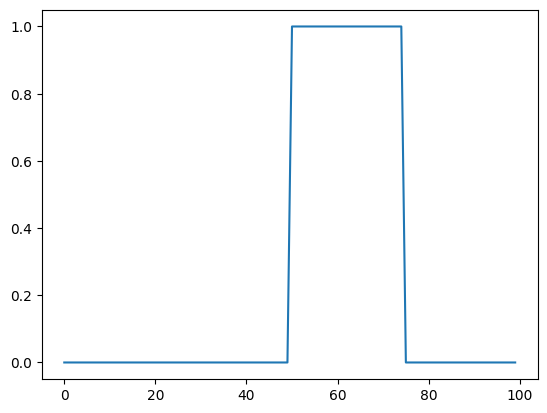

In [6]:
v = np.zeros(100)
v[50:75] = 1

plt.plot(v)

Consider the following kernels $\mathbf{k}$:


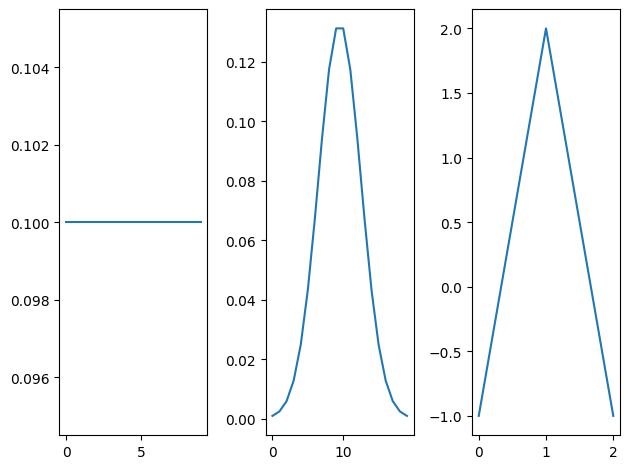

In [4]:
### first kernel
k1 = np.ones(10) / 10

### second kernel
k2 = signal.windows.gaussian(20, std=3)
k2 = k2 / np.sum(k2)

### third kernel
k3 = np.array([-1,2,-1])

fig, ax = plt.subplots(1, 3)
ax[0].plot(k1)
ax[1].plot(k2)
ax[2].plot(k3)

plt.tight_layout()

In what follows, we will compute the convolution between $\mathbf{v}$ and $\mathbf{k}$ in 4 different manners. At the end of each point, plot the obtained filtered (i.e. convolved) signal.


## 1. Toeplitz matrix

Define a Toeplitz matrix $K$ associated with the kernel $\mathbf{k}$.
Then, compute the convolution between $\mathbf{k}$ and $\mathbf{v}$, exploiting the property:

$\mathbf{k} * \mathbf{v} = K \mathbf{v}$


Time taken by matrix-vector product: 0.00019 seconds


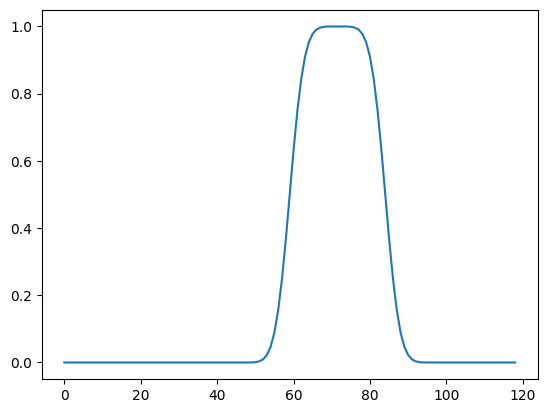

In [10]:
start = time.perf_counter()

k_padded = np.zeros(len(v) + len(k2) - 1)
k_padded[:len(k2)] = k2

K = linalg.toeplitz(k_padded, np.zeros(len(v)))
v_conv1 = K @ v

print(f"Time taken by matrix-vector product: {time.perf_counter() - start:.5f} seconds")

plt.plot(v_conv1)

## 2. Direct definition (sums of products)

The convolution without "boundary layer" (i.e. the part of the vector which is identical between the standard and the circular convolutions), is given by:

$(\mathbf{k} * \mathbf{v})_i = \sum_{j = 0}^{n_k - 1} \mathbf{k}_{n_k - j} \mathbf{v}_{i + j}$

for $i = 1, \dots, n_v - n_k + 1$.


Time taken by direct convolution: 0.00063 seconds


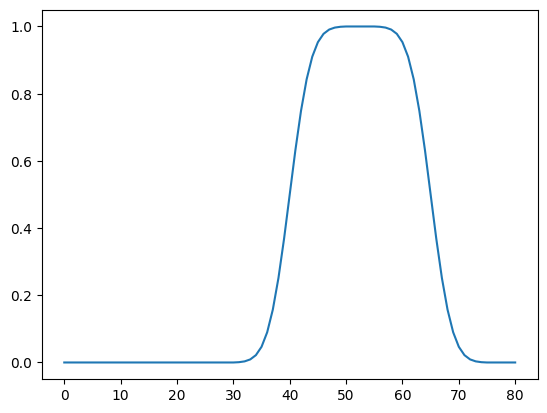

In [14]:
start = time.perf_counter()

l_out = len(v) - len(k2) + 1
v_conv2 = np.array([np.sum(np.flip(k2) * v[i : i + len(k2)]) for i in range(l_out)])

print(f"Time taken by direct convolution: {time.perf_counter() - start:.5f} seconds")
plt.plot(v_conv2)

## 3. Convolution through DFT

When the two signals have the same size, we have:

$ \widehat{\mathbf{v} \circledast \mathbf{k}} = \widehat{\mathbf{v}} \odot \widehat{\mathbf{k}} $

Where:

- $\hat{\mathbf{a}}$ is the DFT of the signal $\mathbf{a}$
- $\circledast$ is the circular convolution
- $\odot$ is the Hadamard product

When the two signals do not have the same size, the above formula can be applied simply by "zero-padding" the shorter signal (N.B: this is automatically done by the `numpy.fft.fft` command by passing the required length as second argument).

Besides the filtered signal, plot the DFT of the two signals and of their convolution.


In [22]:
from numpy.fft import fft, fftfreq, fftshift, ifft

start = time.perf_counter()

v_fft = fft(v)
k_fft = fft(k2, len(v))

vk_fft = v_fft * k_fft
v_conv3 = np.real(ifft(vk_fft))

print(f"Time taken by FFT convolution: {time.perf_counter() - start:.5f} seconds")

freq = fftfreq(len(v))

Time taken by FFT convolution: 0.00017 seconds


Text(0.5, 1.0, 'v * k')

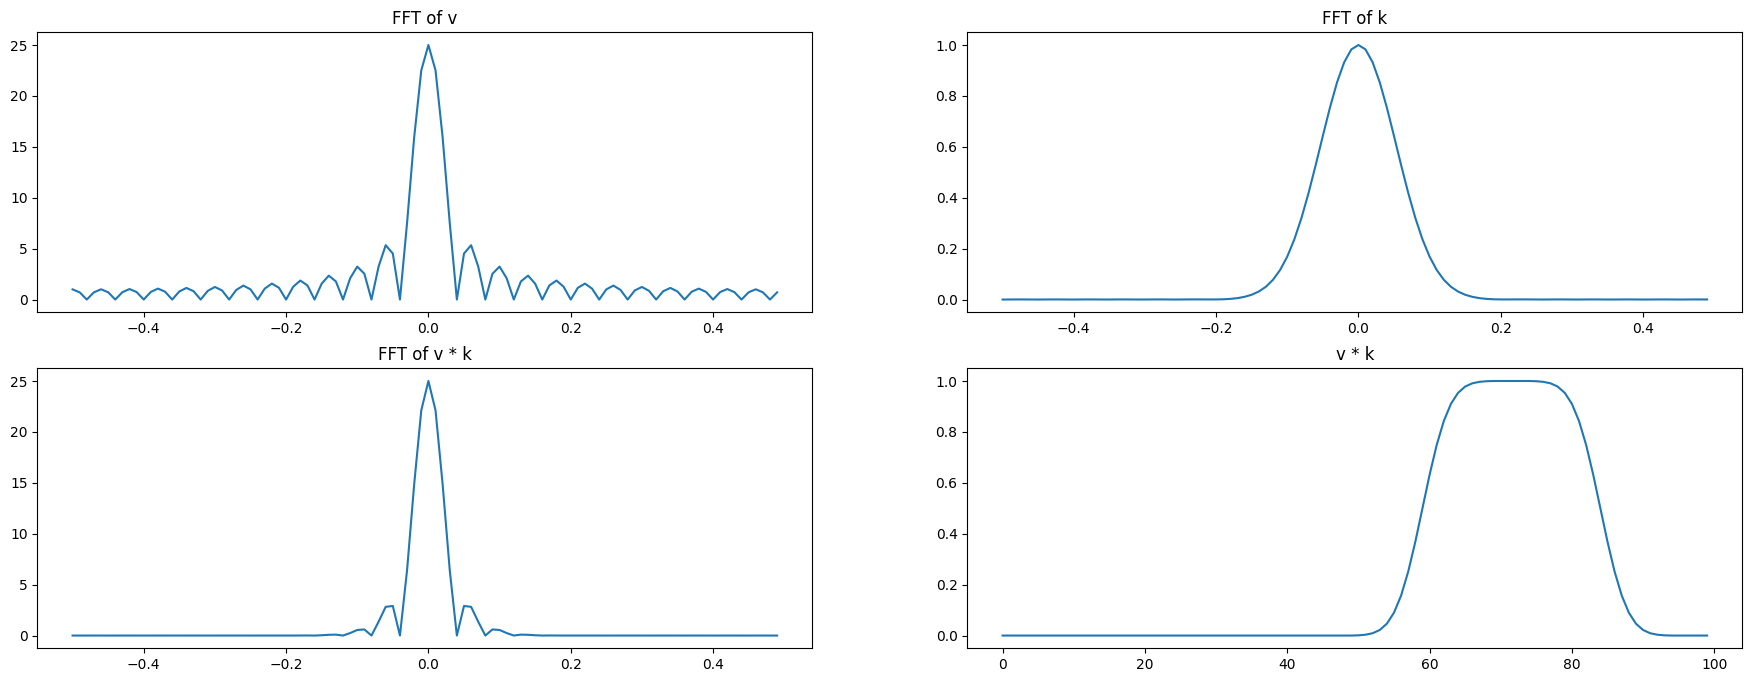

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(22, 8))
axs[0, 0].plot(fftshift(freq), fftshift(np.absolute(v_fft)))
axs[0, 0].set_title("FFT of v")
axs[0, 1].plot(fftshift(freq), fftshift(np.absolute(k_fft)))
axs[0, 1].set_title("FFT of k")
axs[1, 0].plot(fftshift(freq), fftshift(np.absolute(vk_fft)))
axs[1, 0].set_title("FFT of v * k")
axs[1, 1].plot(v_conv3)
axs[1, 1].set_title("v * k")


## 4. Using the command `scipy.signal.convolve`

Time taken by scipy.signal.convolve: 0.00023 seconds


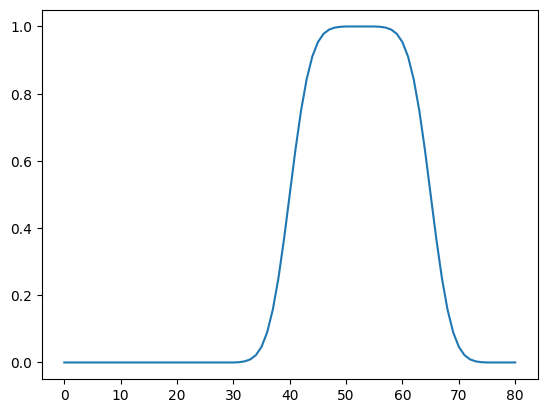

In [25]:
start = time.perf_counter()
v_conv4 = signal.convolve(v, k2, mode="valid")

print(f"Time taken by scipy.signal.convolve: {time.perf_counter() - start:.5f} seconds")

plt.plot(v_conv4)